# Import Packages

In [8]:
import pandas as pd
import seaborn as sb
import os
from matplotlib import pyplot as plt
import scipy
import pingouin as pg
import scipy.stats as stats
import statsmodels
import numpy as np
from math import sqrt
from statsmodels.stats.power import TTestIndPower
import warnings
warnings.filterwarnings('ignore')

### Concatenate all pilot data files

In [10]:
data_list = []
path      = 'pilot_data'

for idx,x in enumerate(os.listdir(path)):
    if x != '.DS_Store' and x[-3:]=='csv':
        df = pd.read_csv(path+'/'+x)
        df['sub_num'] = idx
        data_list.append(df)

### Organize response scores

In [11]:
# Function for organizing data

def organize_data(data):
    '''
    input : original data df
    output: data df with:  - exp_version
                           - score
                           - confidence rating
    '''
    
    # organize scores
    data['proportion_correct'] = np.nan
    
    data.loc[(data['responses'].str.contains('judgement'))
            &(data['responses'].str.contains('0'))
            &(data['correct_answer']==0), 'proportion_correct']=1

    data.loc[(data['responses'].str.contains('judgement'))
                &(data['responses'].str.contains('1'))
                &(data['correct_answer']==1), 'proportion_correct']=1

    data.loc[(data['responses'].str.contains('judgement'))
                &(data['responses'].str.contains('1'))
                &(data['correct_answer']==0), 'proportion_correct']=0

    data.loc[(data['responses'].str.contains('judgement'))
                &(data['responses'].str.contains('0'))
                &(data['correct_answer']==1), 'proportion_correct']=0
    
    # organize confidence ratings
    data['confidence'] = np.nan
    
    for idx,x in data[data['proportion_correct'].notna()].iterrows():
        for a in range(0,4):
            data.loc[idx,'confidence']=int(data.loc[idx+1]['responses'][-2])
    
    # organize experiment version
    data['version'] = np.nan
    maps = 0
    
    for x in list(data['image'].unique()):
        if type(x)==str and "mapOnly" in x:
            maps += 1
            
    if maps>0:
        data['version'] = 'isolated_attention'
    else:
        data['version'] = 'image_attention'
    
    return(data)

### Organize data lists

In [12]:
clean_list = [organize_data(x) for x in data_list]

### Plot data, summary

### General performance

In [13]:
scrambles = [x for x in clean_list if x['version'].unique()[0]=='image_attention']
scrambles_concat = pd.concat(scrambles)

s = scrambles_concat.groupby(['sub_num','version'],as_index=False).mean()

Total percent correct, by experiment


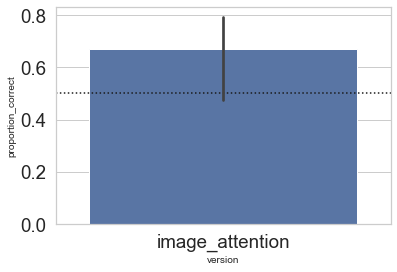

In [14]:
print('Total percent correct, by experiment')

full_concat = pd.concat([s]) #,m])

#grouped_m = maps_concat.groupby(['sub_num','version'],as_index=False).mean()
grouped_s = scrambles_concat.groupby(['sub_num','version'],as_index=False).mean()

sb.set(font_scale=1.7)
sb.set_style("whitegrid")

plt.hlines(.5, -.56, 2.5, colors='k', linestyles='dotted')
sb.barplot(x='version',y='proportion_correct',data=full_concat[full_concat['version']=='image_attention'])
plt.show()

### Performance by Confidence Level

Image Attention (veridical vs. scrambled)

Proportion of correct veridical-vs-scrambled judgements at each confidence level


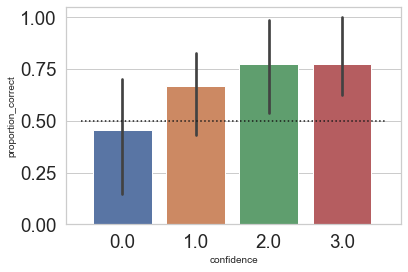

In [15]:
scrambles = [x for x in clean_list if x['version'].unique()[0]=='image_attention']
maps      = [x for x in clean_list if x['version'].unique()[0]=='isolated_attention']

for idx,(a,b) in enumerate(zip(scrambles,maps)):
    
    a['sub_num'] = idx; b['sub_num'] = idx
    scrambles[idx] = a; maps[idx] = b
    
print('Image Attention (veridical vs. scrambled)');print()
print('Proportion of correct veridical-vs-scrambled judgements at each confidence level')
scrambles_concat = pd.concat(scrambles)
grouped_s = scrambles_concat.groupby(['sub_num','confidence','version'],as_index=False).mean()
sb.barplot(x='confidence',y='proportion_correct',data=grouped_s)
# sb.scatterplot(x='confidence',y='proportion_correct',data=grouped_s)

plt.hlines(.5, -.56, 3.6, colors='k', linestyles='dotted')

plt.show()


### Is performance significantly above chance?

Prep stats data

In [16]:
s = scrambles_concat.groupby(['sub_num','version'],as_index=False).mean()

Run stats

In [17]:
stats.ttest_1samp(a=list(full_concat.loc[full_concat['version']=='image_attention','proportion_correct']), popmean=.5)

TtestResult(statistic=1.6942348992060428, pvalue=0.18879374025888918, df=3)

# Determine number of subjects needed (power analysis)

Reference: https://www.geeksforgeeks.org/introduction-to-power-analysis-in-python/

first calculate cohen's d --> (sample_mean - theoretical_mean) / sample_sd

In [18]:
cohen_d_image    = (full_concat.loc[full_concat['version']=='image_attention','proportion_correct'].mean()-.5) / np.std(np.array(full_concat.loc[full_concat['version']=='image_attention','proportion_correct']), ddof=1)

power analysis

In [19]:
# factors for power analysis
alpha = 0.05; power = 0.8

obj = TTestIndPower()
n   = obj.solve_power(effect_size=cohen_d_image, alpha=alpha, power=power, 
                    ratio=1, alternative='larger')
print('Required sample size: '+str(n))

Required sample size: 17.947668918444162
